## Face Masks sold on Etsy.com - Web Scraping

First, you need to download the **Chromium WebDriver** from https://chromedriver.chromium.org/ and place it in the same folder as this notebook.

### 1) Import Libraries

In [1]:
#Load required libraries
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import re
from pymongo import MongoClient
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2) Web Scraper - Selenium & BeautifulSoup4

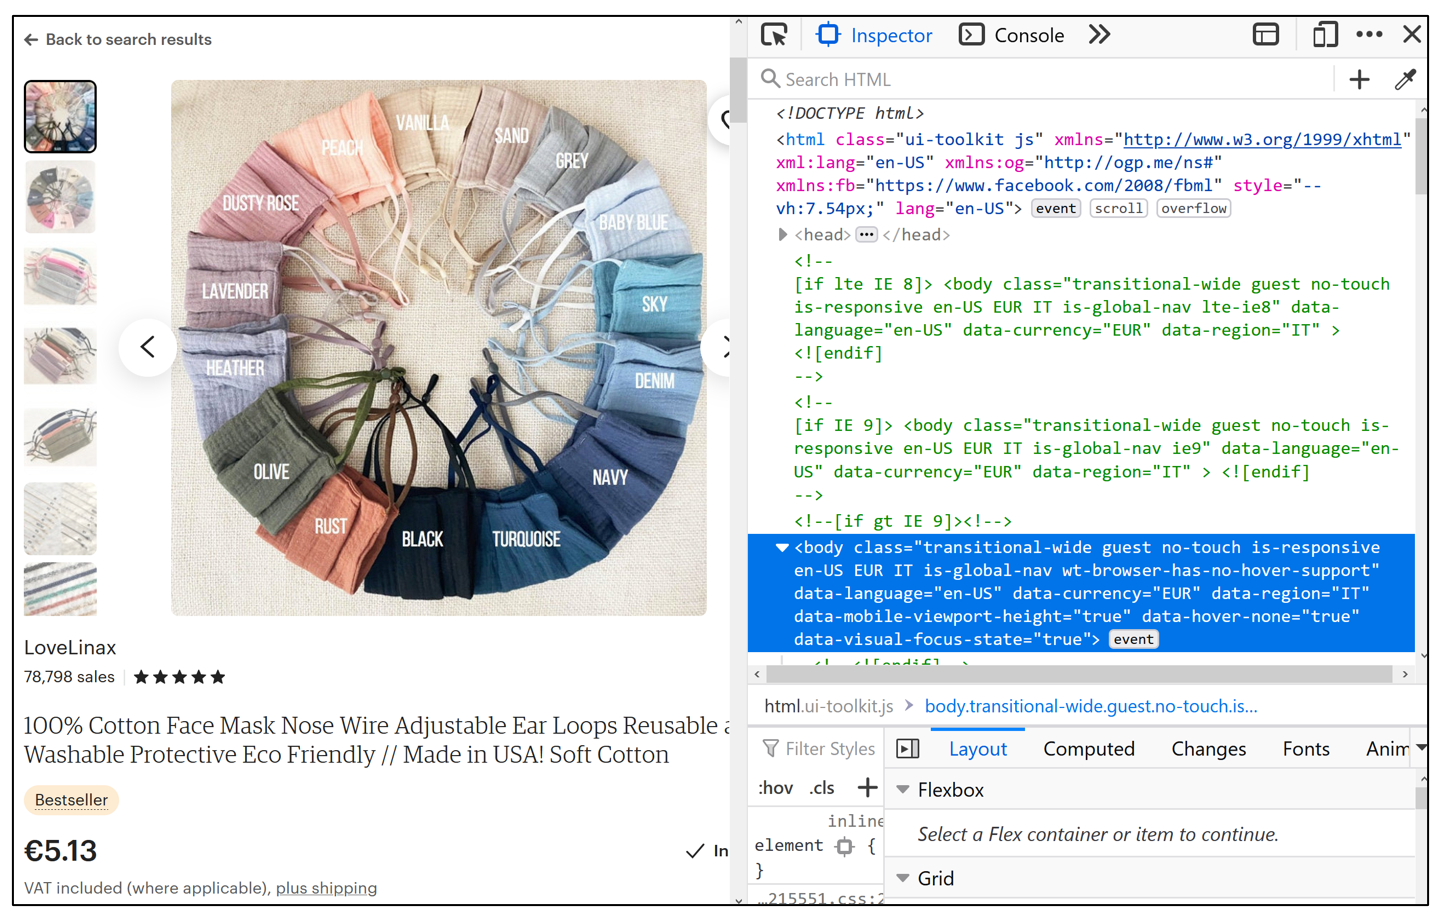

We have created a web scraper using **Selenium** and **BeautifulSoup4**. The scraper is able to "scrape" all key relevant information regarding **face masks sold on Etsy.com**. By *key information* we mean the item's:
* name
* price
* material
* rating
* number of reviews
* shipping location
* first 4 reviews' content
* seller's name
* number of sales

**Notice that:** 
1) The scraper only works with items with: 
* number of reviews >= 1000
* specified material (if the material is not specified it does not work)

2) The .txt file containing the URLs must be in the same folder as this notebook and each URL must be separated from the following one using a ','. The last one must not have the comma at the end.

In [2]:
# initialization of Selenium Web Driver
options = webdriver.ChromeOptions() 
options.add_argument("start-maximized")
options.add_argument("--disable-notifications")
driver = webdriver.Chrome(options = options) 

# list of URLs we want to scrape
urls = open('URLs.txt', 'r') #file containing a list of URLs (must be in the same folder as this notebook)
url_rpt = urls.read().split(",")

# prepare a dictionary to store results
items = {}
documents = []

for url in url_rpt:
       
    # get the page with Selenium
    driver.get(url)

    #extracted page sent to BeautifulSoap parser
    response = BeautifulSoup(driver.page_source, 'html.parser')
    
    # get item's name
    name = response.find(class_="wt-text-body-03 wt-line-height-tight wt-break-word wt-mb-xs-1").text
    name = name.split("\n")[1]
    name = name.strip() #remove leading and trailing spaces
    items['name'] = name

    # get the item's price
    price = response.find(class_="wt-text-title-03 wt-mr-xs-2").text
    price = price.split("EUR")[1] #remove the '€'
    price = float(price.split("+")[0]) #remove the '+' and convert to float
    items['price'] = price 

    # get the item's material
    material = response.find('span', class_="wt-text-body-01").text
    material = material.split("Materials:")[1] #remove unnecessary words
    material = material.strip()
    items['material'] = material
    
    # get the rating
    rating = response.find("input", {'name': "rating"}).attrs['value']
    rating = float(rating) #convert to int
    items['rating'] = rating

    # get the item's number of reviews
    number_of_reviews = response.find(class_="wt-mr-xs-2 wt-text-body-03").text
    number_of_reviews = number_of_reviews.split(" ")[16] #get the number of reviews --> test this 
    thousands = number_of_reviews.split(",")[0] #extract the thousands
    hundreds = number_of_reviews.split(",")[1] #extract the hundreds
    number_of_reviews = int(thousands + hundreds) #concat and convert to int           
    items['number of reviews'] = number_of_reviews

    # get where the item was shipped from
    shipped_from = response.find(class_="wt-grid__item-xs-12 wt-text-black wt-text-caption").text
    shipped_from = shipped_from.split("Dispatches from ")[1] #remove unnecessary words
    shipped_from = shipped_from.split("\n")[0]
    shipped_from = shipped_from.strip()
    items['shipped from'] = shipped_from
    
    # get the first 4 reviews' content
    p_tags = response.find_all("p", 
                              class_="wt-text-truncate--multi-line wt-break-word",
                              limit=4) 
    reviews = []
    content = {}
    i = 0
    for tag in p_tags:
        review = str(tag.text)
        review = review.split("\n")[1] #preliminary text cleaning
        review = review.strip()
        content['id'] = i
        content['content'] = review
        i += 1
        reviews.append(content)
        content = {}
    items['reviews'] = reviews
    
    # get the seller's name
    seller = response.find("p", class_="wt-text-body-03 wt-line-height-tight wt-mb-xs-1")
    seller = str(seller.text)
    items['seller'] = seller
    
    # get the number of sales
    sales = driver.find_element_by_xpath("/html/body/div[5]/div[2]/div[1]/div/div/div[1]/div[2]/div/div[1]/div/div/div/span[1]")
    sales = str(sales.text)
    sales = sales.split(" ")[0] #keep only the number
    thousands = sales.split(",")[0] #extract the thousands
    hundreds = sales.split(",")[1] #extract the hundreds
    sales = int(thousands + hundreds) #concat and convert to int 
    items['number of sales'] = sales

    # insert the item into the list of documents
    documents.append(items)
    
    items = {}

urls.close()
driver.close()
driver.quit()

print(documents)

[{'name': 'UK MADE Silk Face Mask Same Day Dispatch Free Delivery Free Mask Offer Ultra Soft Silk Satin Face Mask Nose Wire+Adjustable Face Mask', 'price': 7.23, 'material': 'NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN', 'rating': 4.8483, 'number of reviews': 11511, 'shipped from': 'United Kingdom', 'reviews': [{'id': 0, 'content': "Wow wow wow! I love these! I brought 3 and they came with a free mask and free chain to keep them around my neck! Perfect for working in a customer service job all day! The material is super soft and breathable and I can comfortably wear these on a 10 hour shift without them itching or overheating me. They have adjustable straps and metal wire over the nose which is strong and doesn't deform. Will definitely be ordering more colours soon"}, {'id': 1, 'content': 'Absolutely incredible! Came quicker than I even imagined, fantastic quality and looks amazing!'}, {'id': 2, 'content': "comfiest mask. I wore it all day on the train and travelling and my makeup stayed 

### 3) Data Manipulation & Analysis

Our aim is to **provide useful insights to people who want to buy a new mask** in order to help them making the best choice. The *key indicators* we display are:
* Highest/Lowest Price
* Average Price
* Highest Quality Mask
* Highest Quality-Price Ratio
* Most Reviewed Mask
* Best Selling Mask

Other metrics and insights are not directly useful for potential buyers, but they are addressed to **manufacturers who want to gain some deeper understanding about the products' landscape**. 

In [3]:
#Creating a dataframe to contain all the information that we have
masks = pd.DataFrame(documents)
masks

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales
0,UK MADE Silk Face Mask Same Day Dispatch Free ...,7.23,"NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN",4.8483,11511,United Kingdom,"[{'id': 0, 'content': 'Wow wow wow! I love the...",KT,147069
1,Mulberry Silk Mask 4 layers Nose wire 100% SIL...,12.40,"Mulberry Silk, Grade 6A 19momme, Durable soft ...",4.8820,15259,United States,"[{'id': 0, 'content': 'Thank you so very much ...",Lanai Ink,119030
2,"Face Mask with Filter, Nose Wire Cotton Facema...",6.85,"Cotton, Round elastic band, Nickel free nose wire",4.7491,17107,Bulgaria,"[{'id': 0, 'content': 'OMG.. got these masks t...",Marcella,97652
3,"Face Mask with Nose Wire, Triple Layers plus F...",2.40,"cotton, elastic, polypropylene, satin, silk",4.8393,7892,United Kingdom,"[{'id': 0, 'content': 'Fantastic design and qu...",vintagelanna,112928
4,Same Day Dispatch - MADE IN UK - Silk Face Ma...,1.35,"SILK, SATIN, ELASTIC",4.7106,8270,United Kingdom,"[{'id': 0, 'content': 'These masks are the mos...",GH,97104
5,"Silk face Mask UK, Silk Mask, Silk face mask, ...",7.24,Mulberry Silk,4.8721,4034,United Kingdom,"[{'id': 0, 'content': 'Thankyou for making sur...",Ava,54095
6,Animal Collection - 3 Layer Hand Embroidered L...,9.40,"linen, cotton",4.9171,1726,United States,"[{'id': 0, 'content': 'Xmas gift to mil. She r...",David and Thanh,13888
7,Best Face mask for Glasses wearers Anti fog US...,9.40,"Japanese cotton, Polyester",4.6789,5304,United States,"[{'id': 0, 'content': 'I ordered one mask to s...",Kim,47635
8,Face mask,6.99,"cotton, poplin mask, cotton mask, fabric mask",4.9336,1124,United Kingdom,"[{'id': 0, 'content': 'Double face, so cute an...",Tippy,12373
9,100% Cotton Face Mask Nose Wire Adjustable Ear...,5.12,Cotton,4.8160,9882,United States,"[{'id': 0, 'content': 'The mask is perfect! Bu...",Love Lina,80078


### 3.a) Masks' Attributes Dashboard

#### > Cheapest / Most Expensive Mask

In [84]:
#Cheapest mask
masks.sort_values(by='price').head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales,Q/P,material_tokens
4,Same Day Dispatch - MADE IN UK - Silk Face Ma...,1.35,"SILK, SATIN, ELASTIC",4.7106,8270,United Kingdom,"[{'id': 0, 'content': 'These masks are the mos...",GH,97104,3.489333,"[SILK, SATIN, ELASTIC]"


In [83]:
cheapest = masks.sort_values(by='price').head(1)
cheapest = cheapest.transpose()
cheapest.columns = ['Cheapest Mask']
cheapest

,Cheapest Mask
name,Same Day Dispatch - MADE IN UK - Silk Face Ma...
price,1.35
material,"SILK, SATIN, ELASTIC"
rating,4.7106
number of reviews,8270
shipped from,United Kingdom
reviews,"[{'id': 0, 'content': 'These masks are the mos..."
seller,GH
number of sales,97104
Q/P,3.48933


In [9]:
#Most Expensive Mask
masks.sort_values(by='price', ascending=False).head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales
10,Pack of 4 - Adult - 3 Layer Cotton Face Mask -...,20.01,cotton,4.917,1386,United States,"[{'id': 0, 'content': 'Super fast shipping. Su...",Bohemian Outsider,7483


In [10]:
#Average Price
avg_price = masks['price'].mean()
print("Average mask price:", avg_price, "(€)")

Average mask price: 7.349375000000002 (€)


#### > Highest Quality Mask

In [11]:
masks.sort_values(by='rating', ascending=False).head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales
15,Super soft silk satin face masks made in the U...,7.73,"Satin, silk",4.9569,2160,United Kingdom,"[{'id': 0, 'content': 'These masks are the BES...",OrchardBloomx,23952


#### > Quality - Price ratio

In [12]:
masks['Q/P'] = masks['rating']/masks['price']

In [13]:
masks.sort_values(by='Q/P', ascending=False).head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales,Q/P
4,Same Day Dispatch - MADE IN UK - Silk Face Ma...,1.35,"SILK, SATIN, ELASTIC",4.7106,8270,United Kingdom,"[{'id': 0, 'content': 'These masks are the mos...",GH,97104,3.489333


In [85]:
highest_qp = masks.sort_values(by='Q/P', ascending=False).head(1)
highest_qp = highest_qp.transpose()
highest_qp.columns = ['Highest Quality-Price Ratio']
highest_qp

,Highest Quality-Price Ratio
name,Same Day Dispatch - MADE IN UK - Silk Face Ma...
price,1.35
material,"SILK, SATIN, ELASTIC"
rating,4.7106
number of reviews,8270
shipped from,United Kingdom
reviews,"[{'id': 0, 'content': 'These masks are the mos..."
seller,GH
number of sales,97104
Q/P,3.48933


#### > Most Reviewed Mask

In [14]:
masks.sort_values(by='number of reviews', ascending=False).head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales,Q/P
2,"Face Mask with Filter, Nose Wire Cotton Facema...",6.85,"Cotton, Round elastic band, Nickel free nose wire",4.7491,17107,Bulgaria,"[{'id': 0, 'content': 'OMG.. got these masks t...",Marcella,97652,0.693299


In [86]:
most_rev = masks.sort_values(by='number of reviews', ascending=False).head(1)
most_rev = most_rev.transpose()
most_rev.columns = ['Most Reviewed']
most_rev

,Most Reviewed
name,"Face Mask with Filter, Nose Wire Cotton Facema..."
price,6.85
material,"Cotton, Round elastic band, Nickel free nose wire"
rating,4.7491
number of reviews,17107
shipped from,Bulgaria
reviews,"[{'id': 0, 'content': 'OMG.. got these masks t..."
seller,Marcella
number of sales,97652
Q/P,0.693299


#### > Best Selling Mask

In [15]:
masks.sort_values(by='number of sales', ascending=False).head(1)

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales,Q/P
0,UK MADE Silk Face Mask Same Day Dispatch Free ...,7.23,"NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN",4.8483,11511,United Kingdom,"[{'id': 0, 'content': 'Wow wow wow! I love the...",KT,147069,0.670581


-----------------------------------------------------------

### 3.b) Masks Market Dashboard

#### > Quality - Price ratio

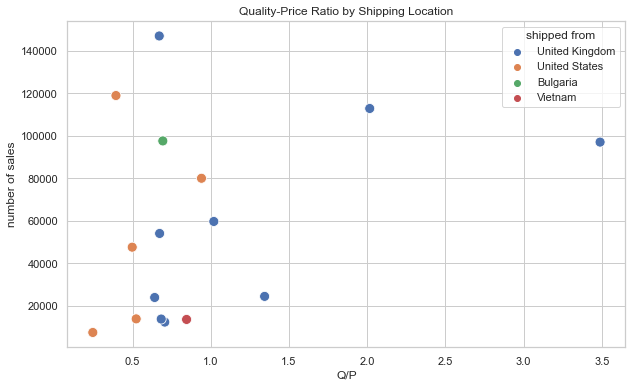

In [16]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x="Q/P", y="number of sales", hue="shipped from", data=masks, s=100)
plt.title("Quality-Price Ratio by Shipping Location")
plt.show()

#### > Most Common Material

In [17]:
masks['material']

0               NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN
1     Mulberry Silk, Grade 6A 19momme, Durable soft ...
2     Cotton, Round elastic band, Nickel free nose wire
3           cotton, elastic, polypropylene, satin, silk
4                                  SILK, SATIN, ELASTIC
5                                         Mulberry Silk
6                                         linen, cotton
7                            Japanese cotton, Polyester
8         cotton, poplin mask, cotton mask, fabric mask
9                                                Cotton
10                                               cotton
11     Cotton, Breathable, Adjustable, Washable, Filter
12    Sequin, Embroidery lace, Pure Cotton, High qua...
13        cotton, machine washable, cotton blend lining
14                     ELASTIC, SILK, SATIN SILK, SATIN
15                                          Satin, silk
Name: material, dtype: object

In [18]:
masks['material_tokens'] = masks['material'].str.split(",")
masks

,name,price,material,rating,number of reviews,shipped from,reviews,seller,number of sales,Q/P,material_tokens
0,UK MADE Silk Face Mask Same Day Dispatch Free ...,7.23,"NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN",4.8483,11511,United Kingdom,"[{'id': 0, 'content': 'Wow wow wow! I love the...",KT,147069,0.670581,"[NOSE WIRE, ELASTIC, TOGGLES, SILK SATIN]"
1,Mulberry Silk Mask 4 layers Nose wire 100% SIL...,12.40,"Mulberry Silk, Grade 6A 19momme, Durable soft ...",4.8820,15259,United States,"[{'id': 0, 'content': 'Thank you so very much ...",Lanai Ink,119030,0.393710,"[Mulberry Silk, Grade 6A 19momme, Durable so..."
2,"Face Mask with Filter, Nose Wire Cotton Facema...",6.85,"Cotton, Round elastic band, Nickel free nose wire",4.7491,17107,Bulgaria,"[{'id': 0, 'content': 'OMG.. got these masks t...",Marcella,97652,0.693299,"[Cotton, Round elastic band, Nickel free nos..."
3,"Face Mask with Nose Wire, Triple Layers plus F...",2.40,"cotton, elastic, polypropylene, satin, silk",4.8393,7892,United Kingdom,"[{'id': 0, 'content': 'Fantastic design and qu...",vintagelanna,112928,2.016375,"[cotton, elastic, polypropylene, satin, silk]"
4,Same Day Dispatch - MADE IN UK - Silk Face Ma...,1.35,"SILK, SATIN, ELASTIC",4.7106,8270,United Kingdom,"[{'id': 0, 'content': 'These masks are the mos...",GH,97104,3.489333,"[SILK, SATIN, ELASTIC]"
5,"Silk face Mask UK, Silk Mask, Silk face mask, ...",7.24,Mulberry Silk,4.8721,4034,United Kingdom,"[{'id': 0, 'content': 'Thankyou for making sur...",Ava,54095,0.672942,[Mulberry Silk]
6,Animal Collection - 3 Layer Hand Embroidered L...,9.40,"linen, cotton",4.9171,1726,United States,"[{'id': 0, 'content': 'Xmas gift to mil. She r...",David and Thanh,13888,0.523096,"[linen, cotton]"
7,Best Face mask for Glasses wearers Anti fog US...,9.40,"Japanese cotton, Polyester",4.6789,5304,United States,"[{'id': 0, 'content': 'I ordered one mask to s...",Kim,47635,0.497755,"[Japanese cotton, Polyester]"
8,Face mask,6.99,"cotton, poplin mask, cotton mask, fabric mask",4.9336,1124,United Kingdom,"[{'id': 0, 'content': 'Double face, so cute an...",Tippy,12373,0.705808,"[cotton, poplin mask, cotton mask, fabric m..."
9,100% Cotton Face Mask Nose Wire Adjustable Ear...,5.12,Cotton,4.8160,9882,United States,"[{'id': 0, 'content': 'The mask is perfect! Bu...",Love Lina,80078,0.940625,[Cotton]


In [19]:
masks['material_tokens']

0          [NOSE WIRE,  ELASTIC,  TOGGLES,  SILK SATIN]
1     [Mulberry Silk,  Grade 6A 19momme,  Durable so...
2     [Cotton,  Round elastic band,  Nickel free nos...
3     [cotton,  elastic,  polypropylene,  satin,  silk]
4                              [SILK,  SATIN,  ELASTIC]
5                                       [Mulberry Silk]
6                                      [linen,  cotton]
7                         [Japanese cotton,  Polyester]
8     [cotton,  poplin mask,  cotton mask,  fabric m...
9                                              [Cotton]
10                                             [cotton]
11    [Cotton,  Breathable,  Adjustable,  Washable, ...
12    [Sequin,  Embroidery lace,  Pure Cotton,  High...
13    [cotton,  machine washable,  cotton blend lining]
14                [ELASTIC,  SILK,  SATIN SILK,  SATIN]
15                                       [Satin,  silk]
Name: material_tokens, dtype: object

In [61]:
words_set = {'silk', 'mulberry silk', 'cotton', 'polypropylene', 'polyester', 'sequin', 'silk satin', 'linen', 'satin silk', 'japanese cotton', 'poplin'} 
materials = []

for word_list in masks['material_tokens']:
    for word in word_list:
        word = word.lower() #convert to lowercase
        #print(word)
        if word in words_set: #extract the materials
            materials.append(word)
            
materials_df = pd.DataFrame(data=materials, columns=['Materials'])
materials_df

,Materials
0,mulberry silk
1,cotton
2,cotton
3,silk
4,mulberry silk
5,linen
6,japanese cotton
7,cotton
8,cotton
9,cotton


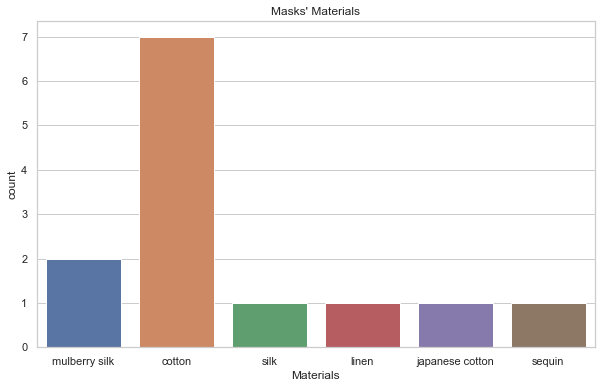

In [62]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Materials', data=materials_df)
plt.title("Masks' Materials")
plt.show()

#### > Shipping Locations

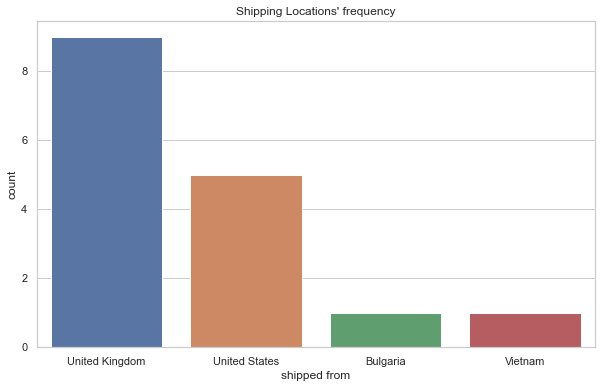

In [59]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='shipped from', data=masks)
plt.title("Shipping Locations' frequency")
plt.show()

#### > Price & Sales

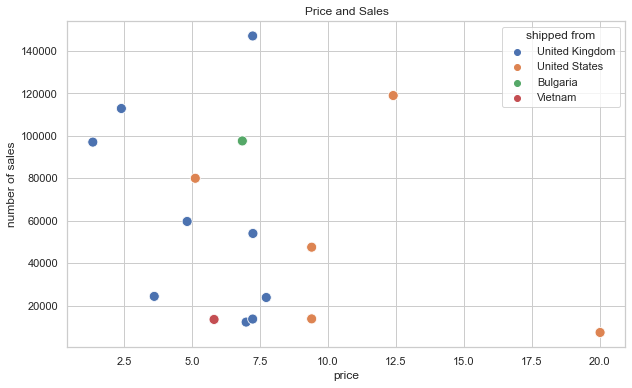

In [60]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x="price", y="number of sales", hue="shipped from", data=masks, s=100)
plt.title("Price and Sales")
plt.show()

#### > Reviews Analysis

In [121]:
masks['reviews'][0]

[{'id': 0,
  'content': "Wow wow wow! I love these! I brought 3 and they came with a free mask and free chain to keep them around my neck! Perfect for working in a customer service job all day! The material is super soft and breathable and I can comfortably wear these on a 10 hour shift without them itching or overheating me. They have adjustable straps and metal wire over the nose which is strong and doesn't deform. Will definitely be ordering more colours soon"},
 {'id': 1,
  'content': 'Absolutely incredible! Came quicker than I even imagined, fantastic quality and looks amazing!'},
 {'id': 2,
  'content': "comfiest mask. I wore it all day on the train and travelling and my makeup stayed on so much better as it's so lightweight and doesn't rub on your skin too much."},
 {'id': 3,
  'content': "Amazing quality, ideal because its adjustable and I've just ordered another one for myself xxx"}]

#### > Picking up one product

In [79]:
pdt = masks.sample(1)
pdt_df = pd.DataFrame(pdt)
pdt_df = pdt_df.drop(['material', 'seller', 'material_tokens', 'reviews'], axis=1)
pdt_df = pdt_df.transpose()
pdt_df.columns = ['Your Product']
pdt_df

,Your Product
name,Super soft silk satin face masks made in the U...
price,7.73
rating,4.9569
number of reviews,2160
shipped from,United Kingdom
number of sales,23952
Q/P,0.641255
